In [44]:
from rich.jupyter import display
# %load_ext cudf.pandas
import cudf as pd
# import pandas as pd
import cv2 as cv
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
from cuml.preprocessing import MinMaxScaler
from scipy.stats import mode
import optuna
from cuml.model_selection import train_test_split
import cupy as cp

import numpy as np
from scipy.stats import skew
import optuna.visualization as vis

In [45]:
train_df = pd.read_csv("./dataset/splits/train.csv", index_col='index')
train_df.head()
test_df = pd.read_csv("./dataset/splits/test.csv", index_col='index')
test_df.head()
val_df = pd.read_csv("./dataset/splits/validation.csv", index_col='index')

In [46]:
def manual_normalize(frame):
    mean, std = cv.meanStdDev(frame)
    mean = mean.flatten()
    std = std.flatten()
    return (frame - mean) / std

def open_cv_normalize(frame):
    return cv.normalize(frame, None, alpha=0, beta=1.0, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

def open_cv_normalization_255(frame):
    return cv.normalize(frame, None, alpha=0, beta=255,
                               norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)


In [47]:
def color_segmentation(frame):
    rgb_frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    hsv_frame = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    resized_rgb = cv.resize(rgb_frame, (224, 224), interpolation=cv.INTER_CUBIC)
    resized_hsv = cv.resize(hsv_frame, (224, 224), interpolation=cv.INTER_CUBIC)

    hist_features = {}
    for i, col in enumerate(['red', 'green', 'blue']):
        hist = cv.calcHist(resized_rgb, [i], None, [256], [0, 256])
        hist_features[col] = hist.flatten()

    moments = []
    for i in range(3):
        channel = resized_hsv[:, :, i]
        mean = cp.mean(channel)
        std = cp.std(channel)
        skewness = skew(channel.flatten())
        if np.isnan(skewness):
            skewness = 0
        moments.append([mean, std, skewness])

    avg_color = cp.mean(resized_rgb, axis=(0, 1))
    return hist_features, moments, avg_color


In [48]:
def add_color_feature_pipeline(index, file_path) -> list:
    file = cv.VideoCapture(file_path)
    results = []
    while file.isOpened():
        if not file:
            print("Error opening video stream or file")
        ret, frame = file.read()

        if ret:
            hist_features, moments, avg_color = color_segmentation(frame)

            results.append({'index': index,
                'moments_mean_h': moments[0][0], 'moments_std_h': moments[0][1], 'moments_skew_h': moments[0][2],
                'moments_mean_s': moments[1][0], 'moments_std_s': moments[1][1], 'moments_skew_s': moments[1][2],
                'moments_mean_v': moments[2][0], 'moments_std_v': moments[2][1], 'moments_skew_v': moments[2][2],
                'avg_color_r': avg_color[0], 'avg_color_g': avg_color[1], 'avg_color_b': avg_color[2]})
        else:
            break
    file.release()
    return results

In [49]:
COLOR_FEATURE_COLUMNS = [
    "moments_mean_h", "moments_std_h", "moments_skew_h",
    "moments_mean_s", "moments_std_s", "moments_skew_s",
    "moments_mean_v", "moments_std_v", "moments_skew_v",
    "avg_color_r", "avg_color_g", "avg_color_b",
]


In [50]:

scaler = MinMaxScaler()


def process_df(df, is_test=False):
    features = []
    for index, row in df.to_pandas().iterrows():
        features += add_color_feature_pipeline(index, row.clip_path)

    color_df = pd.DataFrame(
        columns=['index', 'moments_mean_h', 'moments_std_h', 'moments_skew_h', 'moments_mean_s', 'moments_std_s',
                 'moments_skew_s', 'moments_mean_v', 'moments_std_v', 'moments_skew_v', 'avg_color_r', 'avg_color_g',
                 'avg_color_b'],
        data=features)

    for f in COLOR_FEATURE_COLUMNS:
        color_df[f] = color_df[f].astype(float)
        if is_test:
            color_df[COLOR_FEATURE_COLUMNS] = scaler.transform(color_df[COLOR_FEATURE_COLUMNS])
        else:
            color_df[COLOR_FEATURE_COLUMNS] = scaler.fit_transform(color_df[COLOR_FEATURE_COLUMNS])
    return color_df


In [51]:
def train_pipeline():
    train_color_df = process_df(train_df)
    merged_df = pd.merge(train_df, train_color_df, on='index', how='inner')
    output = merged_df['encoded_label']
    merged_df = merged_df.drop(columns=['index', 'clip_path', 'clip_name', 'label', 'encoded_label'])
    return merged_df, output


In [52]:
def validation_pipeline_prepare():
    test_color_df = process_df(val_df, is_test=True)
    merged_df = pd.merge(test_df, test_color_df, on='index', how='inner')
    merged_df = merged_df.drop(columns=['clip_path', 'clip_name', 'label'])
    return merged_df

def validation_pipeline_score(model, merged_df):
    result = 0
    for video_id, group in merged_df.groupby('index'):
        df = group[COLOR_FEATURE_COLUMNS]
        output = model.predict(df)
        final_ans = output.mode().iloc[0]
        expected = group['encoded_label'].values[0]
        if final_ans == expected:
            result = result + 1
    return result


In [53]:
X, Y = train_pipeline()

/tmp/ipykernel_47569/1789944484.py:17: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



In [54]:
val_df = validation_pipeline_prepare()


In [55]:
def objective_function(trial):
    params = {
        'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e1, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    }
    model = SVC(**params)
    model.fit(X, Y)
    return validation_pipeline_score(model, val_df)

study = optuna.create_study(direction="maximize")
study.optimize(objective_function, n_trials=10, show_progress_bar=True, n_jobs=-1)

[I 2026-01-31 10:43:58,369] A new study created in memory with name: no-name-126b04f7-5c39-4e2b-b8ac-d726c5a67e60


  0%|          | 0/10 [00:00<?, ?it/s]

SVM: 0, Expected: 0
SVM: <class 'numpy.int64'>, Expected: <class 'cupy.ndarray'>
SVM: 0, Expected: 0
SVM: <class 'numpy.int64'>, Expected: <class 'cupy.ndarray'>
SVM: 0, Expected: 0
SVM: <class 'numpy.int64'>, Expected: <class 'cupy.ndarray'>
SVM: 2, Expected: 0
SVM: <class 'numpy.int64'>, Expected: <class 'cupy.ndarray'>
SVM: 2, Expected: 0
SVM: <class 'numpy.int64'>, Expected: <class 'cupy.ndarray'>
SVM: 0, Expected: 0
SVM: <class 'numpy.int64'>, Expected: <class 'cupy.ndarray'>
SVM: 1, Expected: 0
SVM: <class 'numpy.int64'>, Expected: <class 'cupy.ndarray'>
SVM: 0, Expected: 0
SVM: <class 'numpy.int64'>, Expected: <class 'cupy.ndarray'>
SVM: 2, Expected: 0
SVM: <class 'numpy.int64'>, Expected: <class 'cupy.ndarray'>
SVM: 0, Expected: 0
SVM: <class 'numpy.int64'>, Expected: <class 'cupy.ndarray'>
SVM: 0, Expected: 0
SVM: <class 'numpy.int64'>, Expected: <class 'cupy.ndarray'>
SVM: 2, Expected: 0
SVM: <class 'numpy.int64'>, Expected: <class 'cupy.ndarray'>
SVM: 1, Expected: 0
SVM: <cl

In [56]:
best_params = study.best_params
print(best_params)

{'C': 0.019253738288219354, 'gamma': 0.0006217194527957482, 'kernel': 'poly'}


In [57]:

vis.plot_param_importances(study)

In [58]:
vis.plot_optimization_history(study)

In [59]:
def test_pipeline(model):
    test_color_df = process_df(test_df, is_test=True)
    merged_df = pd.merge(test_df, test_color_df, on='index', how='inner')
    merged_df = merged_df.drop(columns=['clip_path', 'clip_name', 'label'])

    result = []
    for video_id, group in merged_df.groupby('index'):
        print(video_id)
        df = group[COLOR_FEATURE_COLUMNS]
        output = model.predict(df)
        final_ans = output.mode().iloc[0]
        expected = group['encoded_label'].values[0].item()
        result.append({
        "video_id": video_id,
        "prediction": final_ans,
        "expected": expected,
        "correct": final_ans == expected})

    ans_df = pd.DataFrame(result).to_pandas()
    print(f"ans - {ans_df.correct.sum()} total - {len(ans_df)}")
    print('classification report:')
    print(classification_report(ans_df['expected'], ans_df['prediction']))

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ConfusionMatrixDisplay.from_predictions(ans_df['expected'], ans_df['prediction'], ax=ax, cmap='Blues')

    model_prob = model.predict_proba(merged_df[COLOR_FEATURE_COLUMNS]).to_pandas()
    print(f"model_prob - {type(model_prob)}, {model_prob.shape}")
    print(model.classes_)
    fig, ax = plt.subplots(figsize=(12, 5))
    y = merged_df["encoded_label"].to_numpy()

    for i, class_label in enumerate(model.classes_):
        y_score = model_prob[class_label].to_numpy()
        y_true = (y == class_label)
        PrecisionRecallDisplay.from_predictions(
            y_true=y_true,
            y_score=y_score,
            name=str(class_label),
            ax=ax,
        )
    ax.set_title('Precision-Recall curve (One vs Rest)')
    plt.show()


In [60]:
model = SVC(**best_params, probability=True)
model.fit(X, Y)

SVC()

0
SVM: 1, Expected: 0, type <class 'numpy.int64'>, <class 'int'>
1
SVM: 2, Expected: 0, type <class 'numpy.int64'>, <class 'int'>
2
SVM: 1, Expected: 0, type <class 'numpy.int64'>, <class 'int'>
3
SVM: 2, Expected: 0, type <class 'numpy.int64'>, <class 'int'>
4
SVM: 1, Expected: 0, type <class 'numpy.int64'>, <class 'int'>
5
SVM: 0, Expected: 0, type <class 'numpy.int64'>, <class 'int'>
6
SVM: 1, Expected: 0, type <class 'numpy.int64'>, <class 'int'>
7
SVM: 1, Expected: 0, type <class 'numpy.int64'>, <class 'int'>
8
SVM: 2, Expected: 0, type <class 'numpy.int64'>, <class 'int'>
9
SVM: 0, Expected: 0, type <class 'numpy.int64'>, <class 'int'>
10
SVM: 1, Expected: 1, type <class 'numpy.int64'>, <class 'int'>
11
SVM: 1, Expected: 1, type <class 'numpy.int64'>, <class 'int'>
12
SVM: 2, Expected: 1, type <class 'numpy.int64'>, <class 'int'>
13
SVM: 1, Expected: 1, type <class 'numpy.int64'>, <class 'int'>
14
SVM: 1, Expected: 1, type <class 'numpy.int64'>, <class 'int'>
15
SVM: 1, Expected:

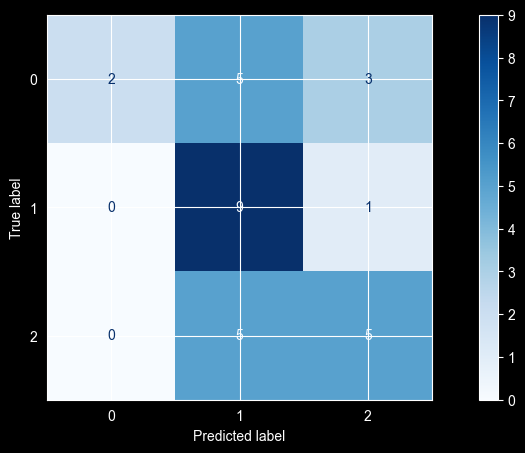

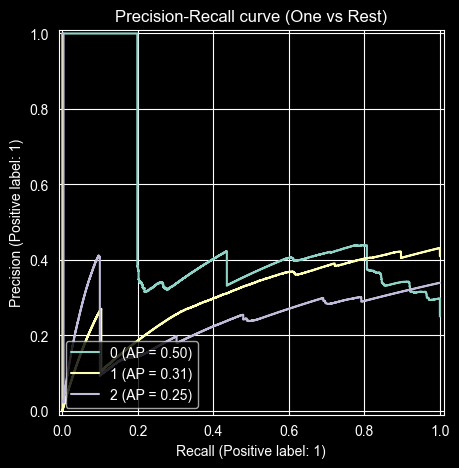

In [61]:
test_pipeline(model)
